In [ ]:
import torch

import triton
import triton.language as tl
from triton.runtime import driver

DEVICE = triton.runtime.driver.active.get_active_torch_device()
print(f"Using device: {DEVICE}")

Using device: cuda:0


In [ ]:

def is_hip():
    return triton.runtime.driver.active.get_current_target().backend == "hip"


def is_cdna():
    return is_hip() and triton.runtime.driver.active.get_current_target().arch in ('gfx940', 'gfx941', 'gfx942',
                                                                                   'gfx90a', 'gfx908')


In [ ]:
def naive_softmax(x):
  x_max = x.max(dim=1)[0] # Get the max on dimension 1.  Max is stored in the first element
  print(f"x_max: {x_max}")
  z = x - x_max[:, None] # prep it so we can do arithmetic operation on a two row matrix
  numerator = torch.exp(z)
  denominator = numerator.sum(dim=1) # denom is the sum of all the exponentials
  return numerator/denominator[:, None]


In [ ]:
@triton.jit
def softmax_kernel(output_ptr, input_ptr, input_row_stride, output_row_stride, n_rows, n_cols, BLOCK_SIZE: tl.constexpr,
                   num_stages: tl.constexpr):
  # starting row of the program
  row_start = tl.program_id(0)
  row_step = tl.num_programs(0) # The number of programs operating on this data
  for row_idx in tl.range(row_start, n_rows, row_step, num_stages=num_stages):
    row_start_ptr = input_ptr + row_idx * input_row_stride

    row_related_offsets = tl.arange(0, BLOCK_SIZE)
    row_mask = row_related_offsets < n_cols
    row = tl.load(row_start_ptr + row_related_offsets, mask=row_mask, other=-float('inf'))

    row_minus_max = row - tl.max(row, axis=0)
    numerator = tl.exp(row_minus_max)
    denominator = tl.sum(numerator, axis=0)
    softmax_output = numerator / denominator
    output_row_ptr = output_ptr + row_idx * output_row_stride
    output_row = output_row_ptr + row_related_offsets
    tl.store(output_row, softmax_output, mask=row_mask)


In [ ]:
properties = driver.active.utils.get_device_properties(DEVICE.index)
NUM_SM = properties["multiprocessor_count"]
NUM_REGS = properties["max_num_regs"]
SIZE_SMEM = properties["max_shared_mem"]
WARP_SIZE = properties["warpSize"]
target = triton.runtime.driver.active.get_current_target()
kernels = {}


def softmax(x):
    n_rows, n_cols = x.shape

    # The block size of each loop iteration is the smallest power of two greater than the number of columns in `x`
    BLOCK_SIZE = triton.next_power_of_2(n_cols)

    # Another trick we can use is to ask the compiler to use more threads per row by
    # increasing the number of warps (`num_warps`) over which each row is distributed.
    # You will see in the next tutorial how to auto-tune this value in a more natural
    # way so you don't have to come up with manual heuristics yourself.
    num_warps = 8

    # Number of software pipelining stages.
    num_stages = 4 if SIZE_SMEM > 200000 else 2

    # Allocate output
    y = torch.empty_like(x)

    # pre-compile kernel to get register usage and compute thread occupancy.
    kernel = softmax_kernel.warmup(y, x, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE,
                                   num_stages=num_stages, num_warps=num_warps, grid=(1, ))
    kernel._init_handles()
    n_regs = kernel.n_regs
    size_smem = kernel.metadata.shared
    if is_hip():
        # NUM_REGS represents the number of regular purpose registers. On CDNA architectures this is half of all registers available.
        # However, this is not always the case. In most cases all registers can be used as regular purpose registers.
        # ISA SECTION (3.6.4 for CDNA3)
        # VGPRs are allocated out of two pools: regular VGPRs and accumulation VGPRs. Accumulation VGPRs are used
        # with matrix VALU instructions, and can also be loaded directly from memory. A wave may have up to 512 total
        # VGPRs, 256 of each type. When a wave has fewer than 512 total VGPRs, the number of each type is flexible - it is
        # not required to be equal numbers of both types.
        NUM_GPRS = NUM_REGS
        if is_cdna():
            NUM_GPRS = NUM_REGS * 2

        # MAX_NUM_THREADS represents maximum number of resident threads per multi-processor.
        # When we divide this number with WARP_SIZE we get maximum number of waves that can
        # execute on a CU (multi-processor)  in parallel.
        MAX_NUM_THREADS = properties["max_threads_per_sm"]
        max_num_waves = MAX_NUM_THREADS // WARP_SIZE
        occupancy = min(NUM_GPRS // WARP_SIZE // n_regs, max_num_waves) // num_warps
    else:
        occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
    occupancy = min(occupancy, SIZE_SMEM // size_smem)
    num_programs = NUM_SM * occupancy

    num_programs = min(num_programs, n_rows)

    # Create a number of persistent programs.
    kernel[(num_programs, 1, 1)](y, x, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE, num_stages)
    return y

In [ ]:
torch.manual_seed(0)
x = torch.randn(1823, 781, device=DEVICE)
y_triton = softmax(x)
y_torch = torch.softmax(x, axis=1)
assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)

x_max: tensor([2.8384, 2.4896, 2.5460,  ..., 2.7414, 2.8485, 3.2890], device='cuda:0')
x_max: tensor([2.8384, 2.4896, 2.5460,  ..., 2.7414, 2.8485, 3.2890], device='cuda:0')
x_max: tensor([2.8384, 2.4896, 2.5460,  ..., 2.7414, 2.8485, 3.2890], device='cuda:0')
x_max: tensor([2.8384, 2.4896, 2.5460,  ..., 2.7414, 2.8485, 3.2890], device='cuda:0')
x_max: tensor([2.8384, 2.4896, 2.5460,  ..., 2.7414, 2.8485, 3.2890], device='cuda:0')
x_max: tensor([2.8384, 2.4896, 2.5460,  ..., 2.7414, 2.8485, 3.2890], device='cuda:0')
x_max: tensor([2.8384, 2.4896, 2.5460,  ..., 2.7414, 2.8485, 3.2890], device='cuda:0')
x_max: tensor([2.8384, 2.4896, 2.5460,  ..., 2.7414, 2.8485, 3.2890], device='cuda:0')
x_max: tensor([2.8384, 2.4896, 2.5460,  ..., 2.7414, 2.8485, 3.2890], device='cuda:0')
x_max: tensor([2.8384, 2.4896, 2.5460,  ..., 2.7414, 2.8485, 3.2890], device='cuda:0')
x_max: tensor([2.8384, 2.4896, 2.5460,  ..., 2.7414, 2.8485, 3.2890], device='cuda:0')
x_max: tensor([2.8384, 2.4896, 2.5460,  ...

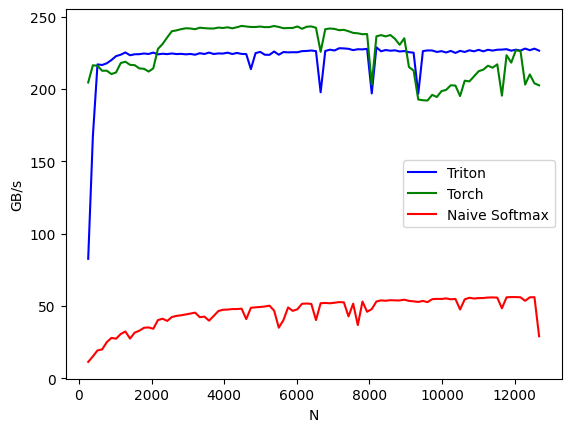

softmax-performance:
          N      Triton       Torch  Naive Softmax
0     256.0   82.611422  204.459365      11.354635
1     384.0  166.936144  216.318339      15.153643
2     512.0  216.946760  216.030768      19.296940
3     640.0  216.546817  212.559951      20.011616
4     768.0  217.721470  212.607386      25.020107
5     896.0  219.970819  210.278856      27.946838
6    1024.0  222.673648  211.427767      27.411918
7    1152.0  223.659916  217.895951      30.647941
8    1280.0  225.198117  218.808156      32.376967
9    1408.0  223.277575  216.641245      27.493441
10   1536.0  223.946591  216.424353      31.604681
11   1664.0  224.029808  214.154390      32.928077
12   1792.0  224.482286  213.935937      34.944017
13   1920.0  224.146880  212.002499      35.187378
14   2048.0  225.102418  214.207897      34.256969
15   2176.0  223.915634  227.656415      40.245635
16   2304.0  224.319237  231.045367      41.223481
17   2432.0  224.066004  235.622161      39.675758
18   2560.

In [ ]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch', 'naive_softmax'],  # possible values for `line_arg``
        line_names=["Triton", "Torch", "Naive Softmax"],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: softmax(x))
    if provider == 'naive_softmax':
        ms = triton.testing.do_bench(lambda: naive_softmax(x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


benchmark.run(show_plots=True, print_data=True)